In [1]:
import argparse
import logging
import os
import sys
import warnings
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from typing import Tuple

import scanpy as sc
import yaml
from anndata import AnnData
from spatialdata import read_zarr

sys.path.insert(1, "/dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark")
from cellseg_benchmark.adata_utils import (
    filter_genes,
    filter_low_quality_cells,
    filter_spatial_outlier_cells,
    merge_adatas,
    normalize_counts,
    pca_umap_single,
)

/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
# reload
from importlib import reload

import cellseg_benchmark.adata_utils as adu

reload(adu)
from cellseg_benchmark.adata_utils import (
    integration_harmony,
) # noqa: E402

In [3]:
def _load_one(
    sample_dir: Path, seg_method: str, logger: logging.Logger
) -> Tuple[str, AnnData | None]:
    """Load AnnData from one master sdata."""
    sdata = read_zarr(sample_dir / "sdata_z3.zarr", selection=("tables",))
    if f"adata_{seg_method}" not in sdata.tables.keys():
        if logger:
            logger.warning(f"Skipping {seg_method}. No such key: {seg_method}")
        return sample_dir.name, None
    return sample_dir.name, sdata[f"adata_{seg_method}"]


warnings.filterwarnings("ignore", ".*The table is annotating*", UserWarning)
sc.settings.n_jobs = -1

In [4]:
# Logger setup
logger = logging.getLogger("integrate_adatas")
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s]: %(message)s"))
logger.addHandler(handler)

In [5]:
# CLI args
# sys.argv = ["notebook", "SynergyLung", "Cellpose_1_Merlin"]
sys.argv = ["notebook", "foxf2", "Cellpose_1_nuclei_model"]
# sys.argv = ["notebook", "foxf2", "Proseg_Cellpose_1_nuclei_model"]
#sys.argv = ["notebook", "aging", "Cellpose_1_nuclei_model"]
sys.argv = ["notebook", "htra1", "Cellpose_1_nuclei_model"]
sys.argv = ["notebook", "foxf2", "Baysor_2D_Cellpose_1_nuclei_model_1.0"]
sys.argv = ["notebook", "foxf2", "Cellpose_1_Merlin"]

parser = argparse.ArgumentParser(
    description="Integrate adatas from a selected segmentation method."
)
parser.add_argument("cohort", help="Cohort name, e.g., 'foxf2'")
parser.add_argument(
    "seg_method", help="Segmentation method, e.g., 'Cellpose_1_nuclei_model'"
)
args = parser.parse_args()
args

Namespace(cohort='foxf2', seg_method='Cellpose_1_Merlin')

In [6]:
base_path = Path("/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark")
samples_path = base_path / "samples"
save_path = base_path / "analysis" / args.cohort / args.seg_method
save_path.mkdir(parents=True, exist_ok=True)

In [7]:
sample_metadata_file, excluded = (
    yaml.safe_load(open(base_path / "misc" / f))
    for f in ["sample_metadata.yaml", "samples_excluded.yaml"]
)
sample_metadata_file

{'foxf2_s1_r0': {'cohort': 'foxf2',
  'slide': 1,
  'region': 0,
  'genotype': 'ECKO',
  'age_months': 6,
  'run_date': '20240229',
  'animal_id': '000',
  'organism': 'mouse',
  'path': '/dss/dssfs03/pn52re/pn52re-dss-0000/202402-Foxf2/merfish_output/20240229_Foxf2-Slide01-cp-WT-ECKO/region_0-ECKO000'},
 'foxf2_s1_r1': {'cohort': 'foxf2',
  'slide': 1,
  'region': 1,
  'genotype': 'WT',
  'age_months': 6,
  'run_date': '20240229',
  'animal_id': '000',
  'organism': 'mouse',
  'path': '/dss/dssfs03/pn52re/pn52re-dss-0000/202402-Foxf2/merfish_output/20240229_Foxf2-Slide01-cp-WT-ECKO/region_1-WT000'},
 'foxf2_s2_r1': {'cohort': 'foxf2',
  'slide': 2,
  'region': 1,
  'genotype': 'WT',
  'age_months': 6,
  'run_date': '20240322',
  'animal_id': '536',
  'organism': 'mouse',
  'path': '/dss/dssfs03/pn52re/pn52re-dss-0000/202402-Foxf2/merfish_output/20240322_Foxf2-Slide02-cp-WT-PCKO/region_1-WT536'},
 'foxf2_s2_r2': {'cohort': 'foxf2',
  'slide': 2,
  'region': 2,
  'genotype': 'PCKO',
  '

In [8]:
excluded_samples = set(excluded.get(args.cohort, []))
excluded_samples

{'foxf2_s2_r0', 'foxf2_s3_r0', 'foxf2_s3_r1'}

In [9]:
yaml_samples = [
    name
    for name, meta in sample_metadata_file.items()
    if meta.get("cohort") == args.cohort and name not in excluded_samples
]
###########################
if args.cohort == "htra1": # add 6/18m WT samples from aging cohort as additional controls
    yaml_samples += ["aging_s1_r0", "aging_s5_r1", "aging_s6_r0", "aging_s7_r2", "aging_s8_r2", "aging_s11_r0"]

In [10]:
yaml_samples

['foxf2_s1_r0',
 'foxf2_s1_r1',
 'foxf2_s2_r1',
 'foxf2_s2_r2',
 'foxf2_s4_r0',
 'foxf2_s4_r1',
 'foxf2_s5_r0',
 'foxf2_s5_r1',
 'foxf2_s6_r0',
 'foxf2_s6_r1',
 'foxf2_s6_r2',
 'foxf2_s7_r0',
 'foxf2_s7_r1']

In [11]:
logger.info("Loading data...")
loads = []
for name in yaml_samples:
    p = samples_path / name
    if not (p / "sdata_z3.zarr").exists():
        logger.error("master sdata in %s not found.", p)
        continue
    loads.append(p)

2025-11-24 16:37:55,485 [INFO]: Loading data...


In [12]:
loads

[PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s1_r0'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s1_r1'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s2_r1'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s2_r2'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s4_r0'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s4_r1'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s5_r0'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s5_r1'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s6_r0'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s6_r1'),
 PosixPath('/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s6_r2'),
 PosixPath('/dss/dssf

In [13]:
#loads = loads[:-5]

In [14]:
%%time
max_workers = int(os.getenv("SLURM_CPUS_PER_TASK", 1))
loader = partial(_load_one, seg_method=args.seg_method, logger=None)
with ProcessPoolExecutor(max_workers=max_workers) as ex:
    results = list(ex.map(loader, loads))

CPU times: user 6.49 s, sys: 18 s, total: 24.4 s
Wall time: 9min 43s


In [15]:
#%%time
#loader = partial(_load_one, seg_method=args.seg_method, logger=logger)
#results = [loader(p) for p in loads[:-5]]

In [16]:
results

[('foxf2_s1_r0',
  AnnData object with n_obs × n_vars = 92590 × 500
      obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'Fth1_raw', 'Fth1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'App_raw', 'App_high_pass', 'Aldoc_raw', 'Aldoc_high_pass', 'Sst_raw', 'Sst_high_pass', 'Plp1_raw', 'Plp1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'spt_region', 'cell_type_incl_low_quality_revised', 'cell_type_mmc_incl_low_quality_clusters', 'cell_type_mmc_incl_low_quality', 'cell_type_incl_mixed_revised', 'cell_type_mmc_incl_mixed_clusters', 'cell_type_mmc_incl_mixed', 'cell_type_revised', 'cell_type_mmc_raw_clusters', 'cell_type_mmc_raw', 'cell_id', 'area', 'volume_sum', 'volume_final', 'num_z_planes', 'size_normalized', 'surface_to_volume_ratio', 'sphericity', 'solidity', 'elongation', 'genotype', 'age_months', 'condition', 'run_date', 'animal_id', 'organism', 'c

In [17]:
# keep YAML order, drop Nones
adata_list = [(name, adata) for name, adata in results if adata is not None]

In [18]:
adata_list

[('foxf2_s1_r0',
  AnnData object with n_obs × n_vars = 92590 × 500
      obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'Fth1_raw', 'Fth1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'App_raw', 'App_high_pass', 'Aldoc_raw', 'Aldoc_high_pass', 'Sst_raw', 'Sst_high_pass', 'Plp1_raw', 'Plp1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'spt_region', 'cell_type_incl_low_quality_revised', 'cell_type_mmc_incl_low_quality_clusters', 'cell_type_mmc_incl_low_quality', 'cell_type_incl_mixed_revised', 'cell_type_mmc_incl_mixed_clusters', 'cell_type_mmc_incl_mixed', 'cell_type_revised', 'cell_type_mmc_raw_clusters', 'cell_type_mmc_raw', 'cell_id', 'area', 'volume_sum', 'volume_final', 'num_z_planes', 'size_normalized', 'surface_to_volume_ratio', 'sphericity', 'solidity', 'elongation', 'genotype', 'age_months', 'condition', 'run_date', 'animal_id', 'organism', 'c

In [19]:
import pandas as pd

In [20]:
# temp fix for aging_s11_r0
for i, (n, ad) in enumerate(adata_list):
    #if n == "aging_s11_r0":
    if "aging" in n:
        m = sample_metadata_file[n]
        for k, v in {**m, "sample": n, "condition": f"{m['genotype']}_{m['age_months']}"} .items():
            ad.obs[k] = pd.Categorical([str(v)] * len(ad))
        adata_list[i] = (n, ad)

In [21]:
#adata_tmp = next((a for n, a in adata_list if n == "aging_s11_r0"), None)

In [22]:
# Merge and process
adata = merge_adatas(
    adata_list,
    seg_method=args.seg_method,
    logger=logger,
    plot_qc_stats=True,
    save_path=save_path / "plots",
)
del adata_list

2025-11-24 16:47:41,492 [INFO]: Merging adatas of Cellpose_1_Merlin
100%|██████████| 13/13 [00:11<00:00,  1.14it/s]
2025-11-24 16:47:56,161 [INFO]: Cellpose_1_Merlin: #cells=1435361, #samples=13
2025-11-24 16:47:56,168 [INFO]: Plotting QC results
/dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark/cellseg_benchmark/adata_utils.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark/cellseg_benchmark/adata_utils.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/dss/dsshome1/0C/ra98gaq/Git/cellseg-benchmark/cellseg_benchmark/adata_utils.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/legacy_api_wrap/__in

In [23]:
adata.obs["sample"].value_counts(dropna=False)

sample
foxf2_s2_r2    141653
foxf2_s4_r0    135961
foxf2_s7_r1    115685
foxf2_s7_r0    114967
foxf2_s5_r1    113471
foxf2_s4_r1    112591
foxf2_s6_r2    111080
foxf2_s2_r1    107013
foxf2_s5_r0    105077
foxf2_s6_r1    104800
foxf2_s1_r1     97566
foxf2_s1_r0     92590
foxf2_s6_r0     82907
Name: count, dtype: int64

In [24]:
adata.obs["condition"].value_counts(dropna=False)

condition
WT_6      430626
PCKO_6    382691
ECKO_6    318652
GLKO_6    303392
Name: count, dtype: int64

In [25]:
adata.obs["cohort"].value_counts(dropna=False)

cohort
foxf2    1435361
Name: count, dtype: int64

In [26]:
adata.obs["age_months"].value_counts(dropna=False)

age_months
6    1435361
Name: count, dtype: int64

In [27]:
import pandas as pd

In [28]:
pd.crosstab(adata.obs["age_months"], adata.obs["sample"], dropna=False)

sample,foxf2_s1_r0,foxf2_s1_r1,foxf2_s2_r1,foxf2_s2_r2,foxf2_s4_r0,foxf2_s4_r1,foxf2_s5_r0,foxf2_s5_r1,foxf2_s6_r0,foxf2_s6_r1,foxf2_s6_r2,foxf2_s7_r0,foxf2_s7_r1
age_months,,,,,,,,,,,,,
6,92590,97566,107013,141653,135961,112591,105077,113471,82907,104800,111080,114967,115685


In [29]:
# workaround to fix adata.obs formatting ###############
# adata.obs["sample"] = adata.obs["sample"].str.replace(
#    rf"^{args.cohort}_(\d+)_(\d+)$", rf"{args.cohort}_s\1_r\2", regex=True
# )
# adata.obs.drop(columns=["spt_region"], inplace=True, errors="ignore")
# adata.obs["condition"] = (
#    adata.obs["genotype"].astype(str) + "_" + adata.obs["age_months"].astype(str)
# )

In [30]:
adata.obs.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x',
       'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio',
       'Fth1_raw', 'Fth1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'App_raw',
       'App_high_pass', 'Aldoc_raw', 'Aldoc_high_pass', 'Sst_raw',
       'Sst_high_pass', 'Plp1_raw', 'Plp1_high_pass', 'PolyT_raw',
       'PolyT_high_pass', 'region', 'slide', 'dataset_id', 'cells_region',
       'cell_type_incl_low_quality_revised',
       'cell_type_mmc_incl_low_quality_clusters',
       'cell_type_mmc_incl_low_quality', 'cell_type_incl_mixed_revised',
       'cell_type_mmc_incl_mixed_clusters', 'cell_type_mmc_incl_mixed',
       'cell_type_revised', 'cell_type_mmc_raw_clusters', 'cell_type_mmc_raw',
       'area', 'volume_sum', 'volume_final', 'num_z_planes', 'size_normalized',
       'surface_to_volume_ratio', 'sphericity', 'solidity', 'elongation',
       'genotype', 'age_months', 'condition', 'run_date', 'animal_id',
       'organism', '

In [129]:
adata.obsm["spatial"] = adata.obsm.get("spatial_microns", adata.obsm["spatial"])
if args.seg_method == "Cellpose_1_Merlin": # workaround, as explorer is in pixel units
    adata.obsm["spatial"] = adata.obsm.get("spatial_pixel", adata.obsm["spatial"])
adata = filter_spatial_outlier_cells(
    adata,
    data_dir=str(base_path),
    sample_metadata_file=sample_metadata_file,
    save_path=save_path / "plots",
    logger=logger,
)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'str'

In [130]:
adata.obsm

AxisArrays with keys: Ovrlpy_stats, blank, ficture_area, ficture_means_weight, ficture_vars_weight, spatial, spatial_microns, spatial_pixel

'Cellpose_1_Merlin'

In [95]:
##################
# dissect filter_spatial_outlier_cells

In [96]:
import math
from os.path import isfile, join
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path

In [97]:
save_path=None
data_dir=str(base_path)
data_dir

'/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark'

In [98]:
n_cols = 3
samples = adata.obs["sample"].unique()
n_samples = len(samples)
n_rows = math.ceil(n_samples / n_cols)

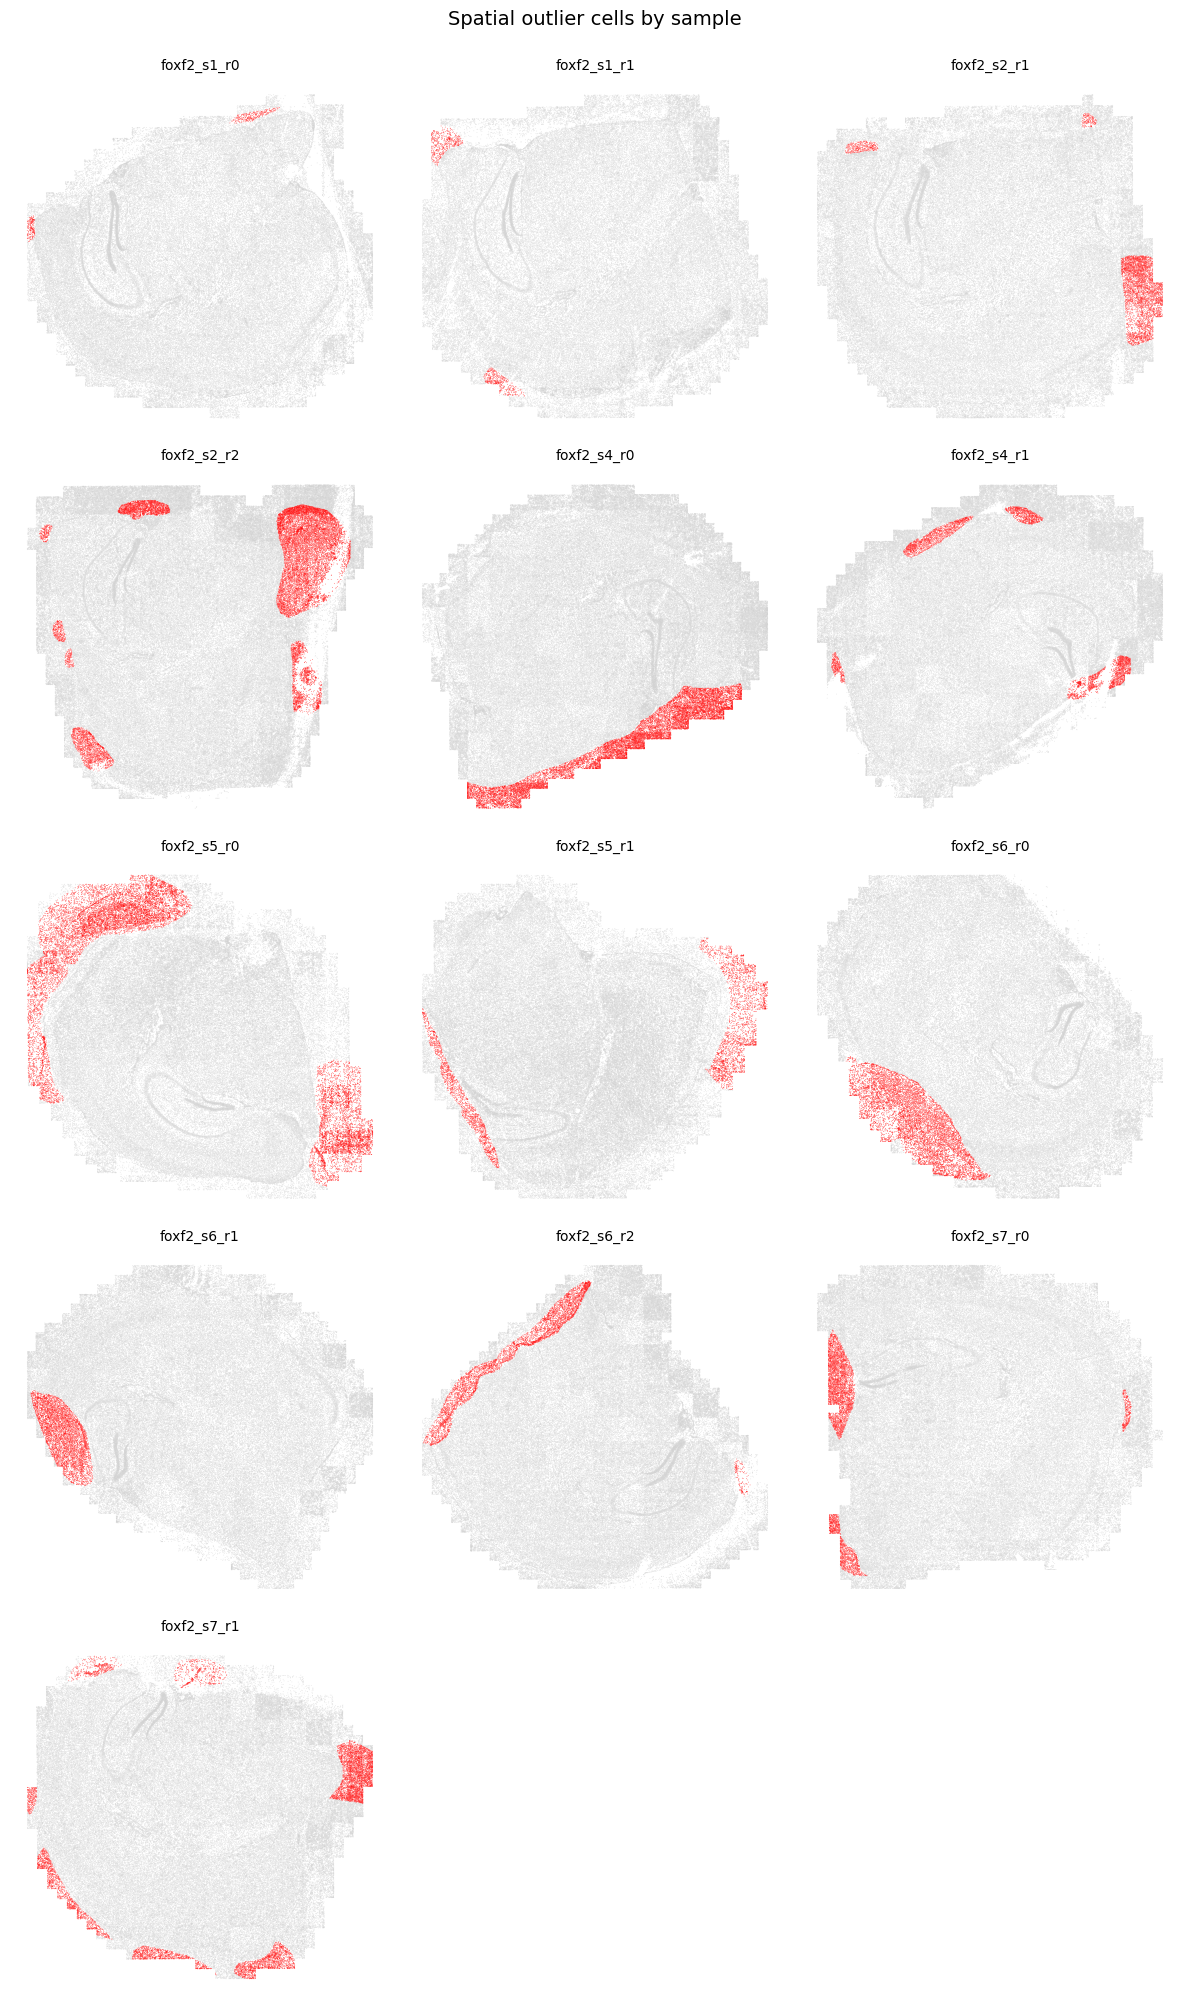

In [99]:
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 4 * n_rows),
    squeeze=False,
    sharex=False,
    sharey=False,
)
adata.obs["spatial_outlier"] = False
for idx, sample in enumerate(samples):
    ax = axes[idx // n_cols][idx % n_cols]
    mask = adata.obs["sample"] == sample
    coords = adata.obsm["spatial"][mask]
    # Subsample for plotting if needed
    sample_data = adata[mask]
    if sample_data.n_obs > int(1.5e5):
        sample_data = sc.pp.subsample(
            sample_data, n_obs=int(1.5e5), random_state=42, copy=True
        )
    plotting_coords = sample_data.obsm["spatial"]
    csv_path = join(data_dir, "samples", sample, "cell_outlier_coordinates.csv")
    if not isfile(csv_path):
        if logger:
            logger.info(
                f"[{sample}] Missing polygon file: {csv_path}. Draw outliers in 10X Explorer if necessary."
            )
        adata.obs.loc[mask, "spatial_outlier"] = False
        # Plot all cells as non-outliers
        ax.scatter(
            plotting_coords[:, 0],
            plotting_coords[:, 1],
            c="lightgrey",
            s=max(0.3, min(0.7, 30000 / len(plotting_coords))),
            alpha=0.75,
            edgecolors="none",
        )
        continue
    coords_df = pd.read_csv(csv_path, skiprows=4)  # skip comment header lines
    if list(coords_df.columns[:3]) != ["Selection", "X", "Y"]:
        raise ValueError(
            f"[{sample}] Unexpected columns in cell_outlier_coordinates.csv: {list(coords_df.columns[:3])}; expected ['Selection', 'X', 'Y']"
        )
    transform = np.loadtxt(
        join(
            sample_metadata_file[sample]["path"],
            "images",
            "micron_to_mosaic_pixel_transform.csv",
        )
    ).reshape(3, 3)
    coords_df[["X", "Y"]] -= transform[[0, 1], 2] / transform[[0, 1], [0, 1]]
    # Detect outliers on full dataset
    outliers = np.zeros(len(coords), dtype=bool)
    for sel in coords_df["Selection"].unique():
        poly = coords_df[coords_df["Selection"] == sel][["X", "Y"]].values
        if len(poly) > 2:
            outliers |= Path(poly).contains_points(coords)
    adata.obs.loc[mask, "spatial_outlier"] = outliers
    # Detect outliers on plotting dataset for visualization
    plotting_outliers = np.zeros(len(plotting_coords), dtype=bool)
    for sel in coords_df["Selection"].unique():
        poly = coords_df[coords_df["Selection"] == sel][["X", "Y"]].values
        if len(poly) > 2:
            plotting_outliers |= Path(poly).contains_points(plotting_coords)
    colors = pd.Categorical(
        np.where(plotting_outliers, "red", "lightgrey"),
        categories=["lightgrey", "red"],
    )
    ax.scatter(
        plotting_coords[:, 0],
        plotting_coords[:, 1],
        c=colors,
        s=max(0.3, min(0.7, 30000 / len(plotting_coords))),
        alpha=0.75,
        edgecolors="none",
    )
    # Draw polygons
    # for sel in coords_df["Selection"].unique():
    #     poly = coords_df[coords_df["Selection"] == sel][["X", "Y"]].values
    #     if len(poly) > 2:
    #         ax.add_patch(Polygon(poly, fill=False, edgecolor="red", linewidth=0.8))
    ax.set_title(sample, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
for ax in axes.flat[n_samples:]:
    ax.set_visible(False)
fig.suptitle("Spatial outlier cells by sample", fontsize=14, y=1)
fig.tight_layout()
#fig.savefig(
#    join(save_path, "qc_spatial_outlier_cells.png"), dpi=200, bbox_inches="tight"
#)
plt.show()

In [110]:
sample = "foxf2_s7_r0"  # adapt to your sample name

In [111]:
ax = axes[idx // n_cols][idx % n_cols]
mask = adata.obs["sample"] == sample
coords = adata.obsm["spatial"][mask]
# Subsample for plotting if needed
sample_data = adata[mask]
if sample_data.n_obs > int(1.5e5):
    sample_data = sc.pp.subsample(
        sample_data, n_obs=int(1.5e5), random_state=42, copy=True
    )
plotting_coords = sample_data.obsm["spatial"]
csv_path = join(data_dir, "samples", sample, "cell_outlier_coordinates.csv")

IndexError: index 18586 is out of bounds for axis 0 with size 3

In [113]:
csv_path

'/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s7_r1/cell_outlier_coordinates.csv'

In [114]:
coords_df = pd.read_csv(csv_path, skiprows=4)  # skip comment header lines
coords_df

,Selection,X,Y
0,Selection 1,3242.517300,5759.877840
1,Selection 1,3288.848589,5765.172844
2,Selection 1,3288.848589,5765.172844
3,Selection 1,3321.942366,5823.417893
4,Selection 1,3382.834917,5847.245412
...,...,...,...
135,Selection 7,1284.353182,926.191224
136,Selection 7,1631.686174,815.676181
137,Selection 7,1716.940635,793.573173
138,Selection 7,1751.673934,793.573173


In [115]:
if list(coords_df.columns[:3]) != ["Selection", "X", "Y"]:
    raise ValueError(
        f"[{sample}] Unexpected columns in cell_outlier_coordinates.csv: {list(coords_df.columns[:3])}; expected ['Selection', 'X', 'Y']"
    )
transform = np.loadtxt(
    join(
        sample_metadata_file[sample]["path"],
        "images",
        "micron_to_mosaic_pixel_transform.csv",
    )
).reshape(3, 3)
coords_df[["X", "Y"]] -= transform[[0, 1], 2] / transform[[0, 1], [0, 1]]

In [116]:
coords_df

,Selection,X,Y
0,Selection 1,3239.868060,5707.195441
1,Selection 1,3286.199349,5712.490445
2,Selection 1,3286.199349,5712.490445
3,Selection 1,3319.293126,5770.735493
4,Selection 1,3380.185677,5794.563013
...,...,...,...
135,Selection 7,1281.703942,873.508825
136,Selection 7,1629.036934,762.993782
137,Selection 7,1714.291395,740.890773
138,Selection 7,1749.024694,740.890773


In [117]:
outliers = np.zeros(len(coords), dtype=bool)
for sel in coords_df["Selection"].unique():
    poly = coords_df[coords_df["Selection"] == sel][["X", "Y"]].values
    if len(poly) > 2:
        outliers |= Path(poly).contains_points(coords)
adata.obs.loc[mask, "spatial_outlier"] = outliers

ValueError: Must have equal len keys and value when setting with an iterable

In [118]:
outliers

array([False, False, False, ..., False, False, False], shape=(115685,))

scale_x: 9.259426116943361 scale_y: 9.259467124938963 mean scale: 9.259446620941162


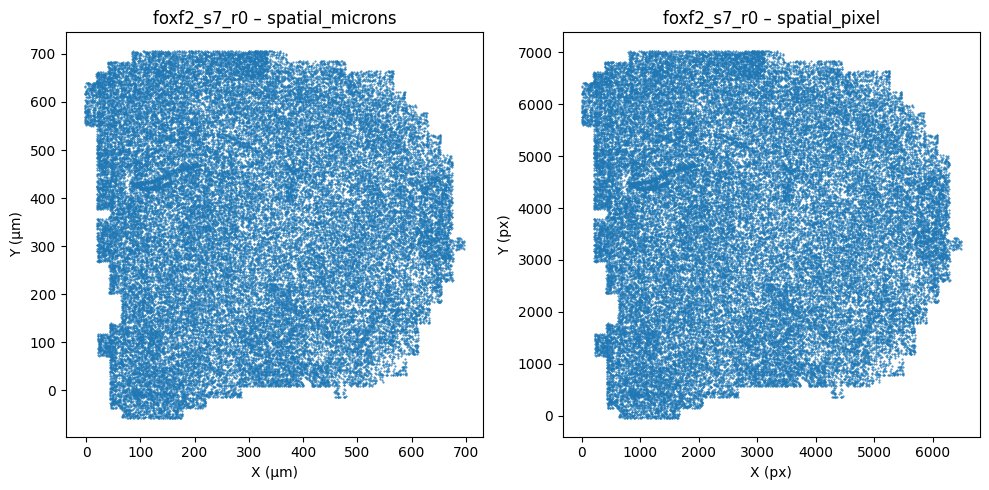

In [123]:
import numpy as np
import matplotlib.pyplot as plt

mask = adata.obs["sample"] == sample
mic = adata.obsm["spatial_microns"][mask]
pix = adata.obsm["spatial_pixel"][mask]

# subsample for plotting speed
n_plot = min(50000, mic.shape[0])
idx = np.random.default_rng(0).choice(mic.shape[0], n_plot, replace=False)
mic = mic[idx]
pix = pix[idx]

# compute effective scale
scale_x = np.ptp(pix[:, 0]) / np.ptp(mic[:, 0])
scale_y = np.ptp(pix[:, 1]) / np.ptp(mic[:, 1])
scale_mean = (scale_x + scale_y) / 2
print("scale_x:", scale_x, "scale_y:", scale_y, "mean scale:", scale_mean)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# microns
axes[0].scatter(mic[:, 0], mic[:, 1], s=0.2)
axes[0].set_title(f"{sample} – spatial_microns")
axes[0].set_xlabel("X (µm)")
axes[0].set_ylabel("Y (µm)")

# pixels
axes[1].scatter(pix[:, 0], pix[:, 1], s=0.2)
axes[1].set_title(f"{sample} – spatial_pixel")
axes[1].set_xlabel("X (px)")
axes[1].set_ylabel("Y (px)")


plt.tight_layout()
plt.show()


scale_x: 9.259426116943361 scale_y: 9.259467124938963 mean scale: 9.259446620941162


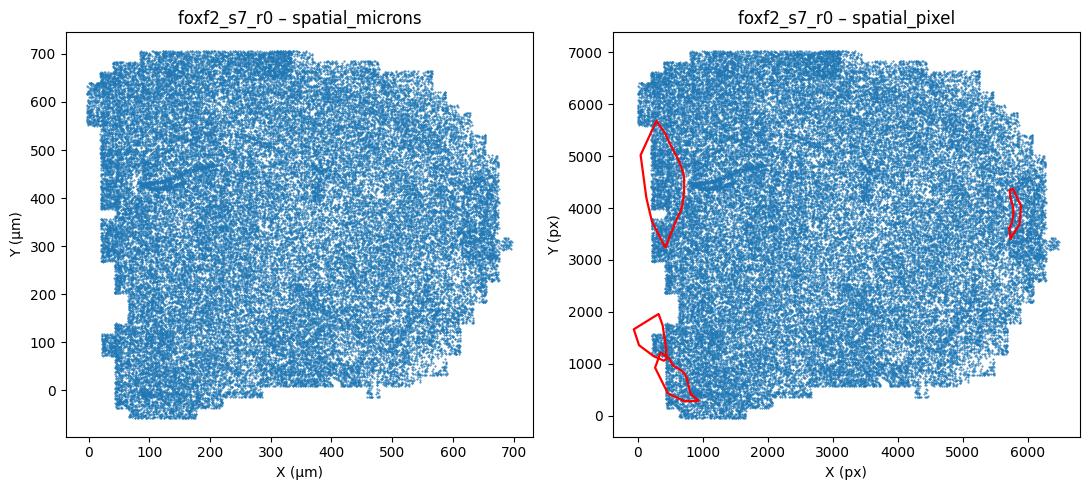

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join

sample = "foxf2_s7_r0"  # current sample

mask = adata.obs["sample"] == sample
mic = adata.obsm["spatial_microns"][mask]
pix = adata.obsm["spatial_pixel"][mask]

# subsample for plotting speed
n_plot = min(50000, mic.shape[0])
idx = np.random.default_rng(0).choice(mic.shape[0], n_plot, replace=False)
mic = mic[idx]
pix = pix[idx]

# compute effective scale
scale_x = np.ptp(pix[:, 0]) / np.ptp(mic[:, 0])
scale_y = np.ptp(pix[:, 1]) / np.ptp(mic[:, 1])
scale_mean = (scale_x + scale_y) / 2
print("scale_x:", scale_x, "scale_y:", scale_y, "mean scale:", scale_mean)

# load polygon boundaries (as exported from Explorer; assumed in pixel coords)
csv_path = join(data_dir, "samples", sample, "cell_outlier_coordinates.csv")
coords_df = pd.read_csv(csv_path, skiprows=4)   # columns: Selection, X, Y

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# microns
axes[0].scatter(mic[:, 0], mic[:, 1], s=0.2)
axes[0].set_title(f"{sample} – spatial_microns")
axes[0].set_xlabel("X (µm)")
axes[0].set_ylabel("Y (µm)")

# pixels + polygon boundaries
axes[1].scatter(pix[:, 0], pix[:, 1], s=0.2)
for sel in coords_df["Selection"].unique():
    poly = coords_df.loc[coords_df["Selection"] == sel, ["X", "Y"]].values
    if len(poly) > 2:
        axes[1].plot(poly[:, 0], poly[:, 1], linewidth=1.6, color="red")
axes[1].set_title(f"{sample} – spatial_pixel")
axes[1].set_xlabel("X (px)")
axes[1].set_ylabel("Y (px)")

plt.tight_layout()
plt.show()


In [ ]:
################## end

In [32]:
#args.cohort == "SynergyLung"

In [33]:
if "vpt_3D" in args.seg_method:  # min_counts=10 due to smaller cell sizes
    min_counts = 10
elif args.cohort == "SynergyLung":  # more lenient for initial analysis
    min_counts = 15
else:
    min_counts = None  # default = 25

In [50]:
adata = filter_low_quality_cells(
    adata,
    save_path=save_path / "plots",
    **({"min_counts": min_counts} if min_counts is not None else {}),
    logger=logger,
)

adata = filter_genes(adata, save_path=save_path / "plots", logger=logger)

adata = normalize_counts(
    adata, save_path=save_path / "plots", seg_method=args.seg_method, logger=logger
)

2025-11-24 11:08:56,688 [INFO]: # total cells before filtering low-quality or volume outliers: 2230303
2025-11-24 11:08:56,690 [INFO]: # low_quality_cell:             260381
2025-11-24 11:08:56,691 [INFO]: # volume_outlier_cell:       51866
2025-11-24 11:09:21,653 [INFO]: # total cells after filtering low-quality or volume outliers:  1927952
2025-11-24 11:09:21,657 [INFO]: # genes before filtering: 500
2025-11-24 11:09:29,189 [INFO]: # genes after filtering: 500
2025-11-24 11:09:34,795 [INFO]: Normalizing counts...
2025-11-24 11:09:39,165 [INFO]: Cells before/after outlier removal during normalization: 1927952 -> 1889392
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [51]:
adata = pca_umap_single(adata, save_path=save_path / "plots", logger=logger)

2025-11-24 11:10:19,914 [INFO]: Dimensionality reduction: PCA
2025-11-24 11:12:20,373 [INFO]: Dimensionality reduction: UMAP with n_neighbors=20, n_pcs=50
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
!mamba install bioconda::harmonypy -y


Looking for: ['bioconda::harmonypy']

warning  libmamba Cache file "/home/ubuntu/miniforge3/pkgs/cache/497deca9.json" was modified by another program
warning  libmamba Cache file "/home/ubuntu/miniforge3/pkgs/cache/09cdf8bf.json" was modified by another program
[+] 0.0s
bioconda/linux-64 (check zst) ━━━━━━━━━━━━━╸━   0.0 B @  ??.?MB/s Checking  0.0sbioconda/linux-64 (check zst)                       Checked  0.1s
[+] 0.0s
bioconda/noarch (check zst)                        Checked  0.0s
[+] 0.0s
conda-forge/linux-64 ━━━━━━━━━━━━╸━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.0s[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━━━━━━━━━━━━━━━  29.1kB /  49.0MB @ 524.2kB/s  0.1s
conda-forge/noarch   ╸━━━━━━━━━━━━━━━╸━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
bioconda/linux-64    ━╸━━━━━━━━━━━━━━━╸━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
bioconda/noarch      ━━━━━━━━━━━╸━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s[+] 0.2s
conda-forge/linux-64 ━━━━━━━━━━━━━━━━━━━━━━━   2.2MB /  49.0MB @  13.4MB/s  0.

In [53]:
adata.obs.columns

Index(['region', 'slide', 'cell_type_incl_low_quality_revised',
       'cell_type_mmc_incl_low_quality_clusters',
       'cell_type_mmc_incl_low_quality', 'cell_type_incl_mixed_revised',
       'cell_type_mmc_incl_mixed_clusters', 'cell_type_mmc_incl_mixed',
       'cell_type_revised', 'cell_type_mmc_raw_clusters', 'cell_type_mmc_raw',
       'area', 'volume_sum', 'volume_final', 'num_z_planes', 'size_normalized',
       'surface_to_volume_ratio', 'sphericity', 'solidity', 'elongation',
       'genotype', 'age_months', 'condition', 'run_date', 'animal_id',
       'organism', 'cohort', 'sample', 'n_counts', 'n_genes',
       'spatial_outlier', 'low_quality_cell', 'volume_outlier_cell'],
      dtype='object')

In [ ]:
%%time
adata = integration_harmony(
    adata,
    batch_key="slide",
    save_path=save_path / "plots",
    logger=logger,
)

2025-11-24 12:18:59,651 [INFO]: Integration: Run Harmony
2025-11-24 12:19:02,258 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-24 12:22:09,997 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-24 12:22:20,986 - harmonypy - INFO - Iteration 1 of 10
2025-11-24 12:36:32,070 - harmonypy - INFO - Iteration 2 of 10
2025-11-24 12:50:32,551 - harmonypy - INFO - Iteration 3 of 10
2025-11-24 13:04:33,393 - harmonypy - INFO - Iteration 4 of 10
2025-11-24 13:18:27,418 - harmonypy - INFO - Iteration 5 of 10


In [ ]:
logger.info("Saving integrated object...")
if "fov" not in adata.obs.columns:
    adata.obs["fov"] = ""
adata.obs["fov"] = adata.obs["fov"].astype(str)
output_path = save_path / "adatas"
output_path.mkdir(parents=True, exist_ok=True)
adata.write(output_path / "adata_integrated.h5ad.gz", compression="gzip")

In [ ]:
adata

In [10]:
###############################################
# load adata post hoc
output_path = save_path / "adatas"
adata = sc.read_h5ad(output_path / "adata_integrated.h5ad.gz")

In [11]:
adata.shape

(996164, 451)

In [12]:
adata

AnnData object with n_obs × n_vars = 996164 × 451
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'Txnip_raw', 'Txnip_high_pass', 'Fth1_raw', 'Fth1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'Scgb1a1_raw', 'Scgb1a1_high_pass', 'Sftpc_raw', 'Sftpc_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Ifitm3_raw', 'Ifitm3_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'area', 'volume_sum', 'volume_final', 'num_z_planes', 'size_normalized', 'surface_to_volume_ratio', 'sphericity', 'solidity', 'elongation', 'condition', 'run_date', 'organism', 'cohort', 'sample', 'n_counts', 'n_genes', 'Col1_raw', 'Col1_high_pass', 'spatial_outlier', 'low_quality_cell', 'volume_outlier_cell'
    var: 'n_cells'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap_20_50', 'X_umap_harmony_20_50', 'X_umap_harmony_20_50_3d', 'blank', 'spatial', 'spatial_microns', 'spatial_pixel'
    varm: 'PCs'
    layers: 'counts', 'libr

In [32]:
#######
# spatial plots post-hoc plotting
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc


def _plot_flag(flag):
    n_cols = 3
    samples = adata.obs["sample"].unique()
    n_samples = len(samples)
    n_rows = math.ceil(n_samples / n_cols)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 4 * n_rows),
        squeeze=False,
        sharex=False,
        sharey=False,
    )

    for idx, sample in enumerate(samples):
        ax = axes[idx // n_cols][idx % n_cols]

        mask = adata.obs["sample"] == sample
        sample_data = adata[mask]

        if sample_data.n_obs > int(1.5e5):
            sample_data = sc.pp.subsample(
                sample_data, n_obs=int(1.5e5), random_state=42, copy=True
            )

        coords = sample_data.obsm["spatial"]

        outliers = sample_data.obs[flag].values
        colors = pd.Categorical(
            np.where(outliers, "grey", "lightgrey"), categories=["lightgrey", "grey"]
        )

        ax.scatter(
            coords[:, 0],
            coords[:, 1],
            c=colors,
            s=max(0.3, min(0.7, 30000 / len(coords))),
            alpha=0.75,
            edgecolors="none",
        )
        ax.set_title(sample, fontsize=10)

        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Hide unused subplots
    for ax in axes.flat[n_samples:]:
        ax.set_visible(False)

    fig.suptitle(f"{flag.replace('_', ' ').title()} by sample", fontsize=14, y=1)
    fig.tight_layout()
    # fig.savefig(join(save_path, fname), dpi=200, bbox_inches="tight")
    # plt.close(fig)
    plt.show(fig)

In [ ]:
_plot_flag("cohort")